# Name Disambiguation

## enviroment setup

In [119]:
import numpy as np
import pandas as pd
import json
import re
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import word2vec

plt.rcParams['axes.unicode_minus'] = False


## global variables

In [120]:
TRAIN_AUTHOR = "./data/train/train_author.json"
TRAIN_PUB = "./data/train/train_pub.json"

SNA_VALID_AUTHOR_RAW = "./data/sna_data/sna_valid_author_raw.json"
SNA_VALID_EXAMPLE = "./data/sna_data/sna_valid_example_evaluation_scratch.json"
SNA_VALID_PUB = "./data/sna_data/sna_valid_pub.json"

## utils

In [83]:
def load_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

        
    

## explore the data

In [121]:
train_author_data = load_json(TRAIN_AUTHOR)
train_pub_data = load_json(TRAIN_PUB)
test_author_data = load_json(SNA_VALID_AUTHOR_RAW)
test_pub_data = load_json(SNA_VALID_PUB)
example_output = load_json(SNA_VALID_EXAMPLE)
 

### example

In [122]:
train_author_name_list = sorted(list(train_author_data.keys()))
print("train author names: ", train_author_name_list)


print("\n\n\ntest author output:")
TEST_NAME = "j_y_wang" #"guoliang_li"
for k, v in train_author_data.items():
    for idx, (id_, paper) in enumerate(v.items()):
        if k == TEST_NAME:
            print(f"index: {idx}, name: {k}, author id: {id_}, paper id list: {paper}")

    





train author names:  ['akio_kobayashi', 'akira_ono', 'alessandro_giuliani', 'alexander_belyaev', 'bai_yang', 'baoli_zhu', 'bin_gao', 'bin_hu', 'bin_yao', 'bin_zhang', 'bin_zhao', 'bing_chen', 'bing_zhang', 'bing_zhao', 'bo_jiang', 'bo_shen', 'bo_zhang', 'bo_zhou', 'c_c_lin', 'c_c_wang', 'c_yang', 'changhong_wang', 'changming_liu', 'changsheng_li', 'chao_chen', 'chao_deng', 'chao_yuan', 'chao_zhang', 'chen_liu', 'cheng_yang', 'cheng_zhu', 'chenguang_wang', 'chuan_he', 'chunxia_li', 'd_li', 'd_zhang', 'dan_wang', 'dan_wu', 'di_wang', 'di_wu', 'di_zhang', 'dong_xu', 'dongsheng_wang', 'f_liu', 'fang_wang', 'fei_liu', 'fei_qi', 'feng_gao', 'feng_li', 'feng_liu', 'feng_wu', 'feng_zhao', 'feng_zhu', 'furong_gao', 'gang_pan', 'gang_zhang', 'guang_yang', 'guanghua_li', 'guochun_zhao', 'guohua_chen', 'guoliang_li', 'guoqing_hu', 'hai_jin', 'hai_yang', 'haijiang_wang', 'haiying_wang', 'hao_huang', 'hao_yan', 'heqing_huang', 'hideaki_takahashi', 'hiroaki_okamoto', 'hiroshi_sakamoto', 'hong_cheng',

In [126]:

print(f"train pub exmaple, author: name: {TEST_NAME}")
print("papers from the same author:")
pprint(train_pub_data["UHYujqML"]["authors"])
print()
pprint(train_pub_data["b3ZiQ3LB"]["authors"])
print()
pprint(train_pub_data["nX5dPm1V"]["authors"])

print("\n\npapers from differet author:")
pprint(train_pub_data["lNpXU2Oo"]["authors"])
pprint(train_pub_data["77H13FlR"]["authors"])
pprint(train_pub_data["NwjJw4ks"]["authors"])

train pub exmaple, author: name: j_y_wang
papers from the same author:
[{'name': 'X.B. Hu', 'org': ''},
 {'name': 'J.Y. Wang', 'org': ''},
 {'name': 'W.H. Cui', 'org': ''},
 {'name': 'Q.C. Guan', 'org': ''},
 {'name': 'R.B. Song', 'org': ''},
 {'name': 'J.Q. Wei', 'org': ''},
 {'name': 'Y.G. Liu', 'org': ''},
 {'name': 'J.H. Jiang', 'org': ''},
 {'name': 'Y.L. Tian', 'org': ''}]

[{'name': 'Q.T. Gu', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'J.Q. Wei', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'M.K. Lu', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'H.S. Zhuo', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'J.Y. Wang', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'C.S. Fang', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'G. Landwehr', 'org': 'Physikalisches Inst. Univ. Wurzburg'},
 {'name': 'H. Reß', 'org': 'Physikalisches Inst. Univ. Wurzburg'}]

[{'name': 'C.S. Fang', 'org': 'Stt. Key Lab. of Crystal Materials'},

## data statistics

### training data

author name count before disambiguation:  221
author name count after disambiguation: 22839
average count per author name  before disambiguation:  103.34
total paper count: 205498
average paper per author (before disambiguation): 930
average paper per author (after disambiguation): 9


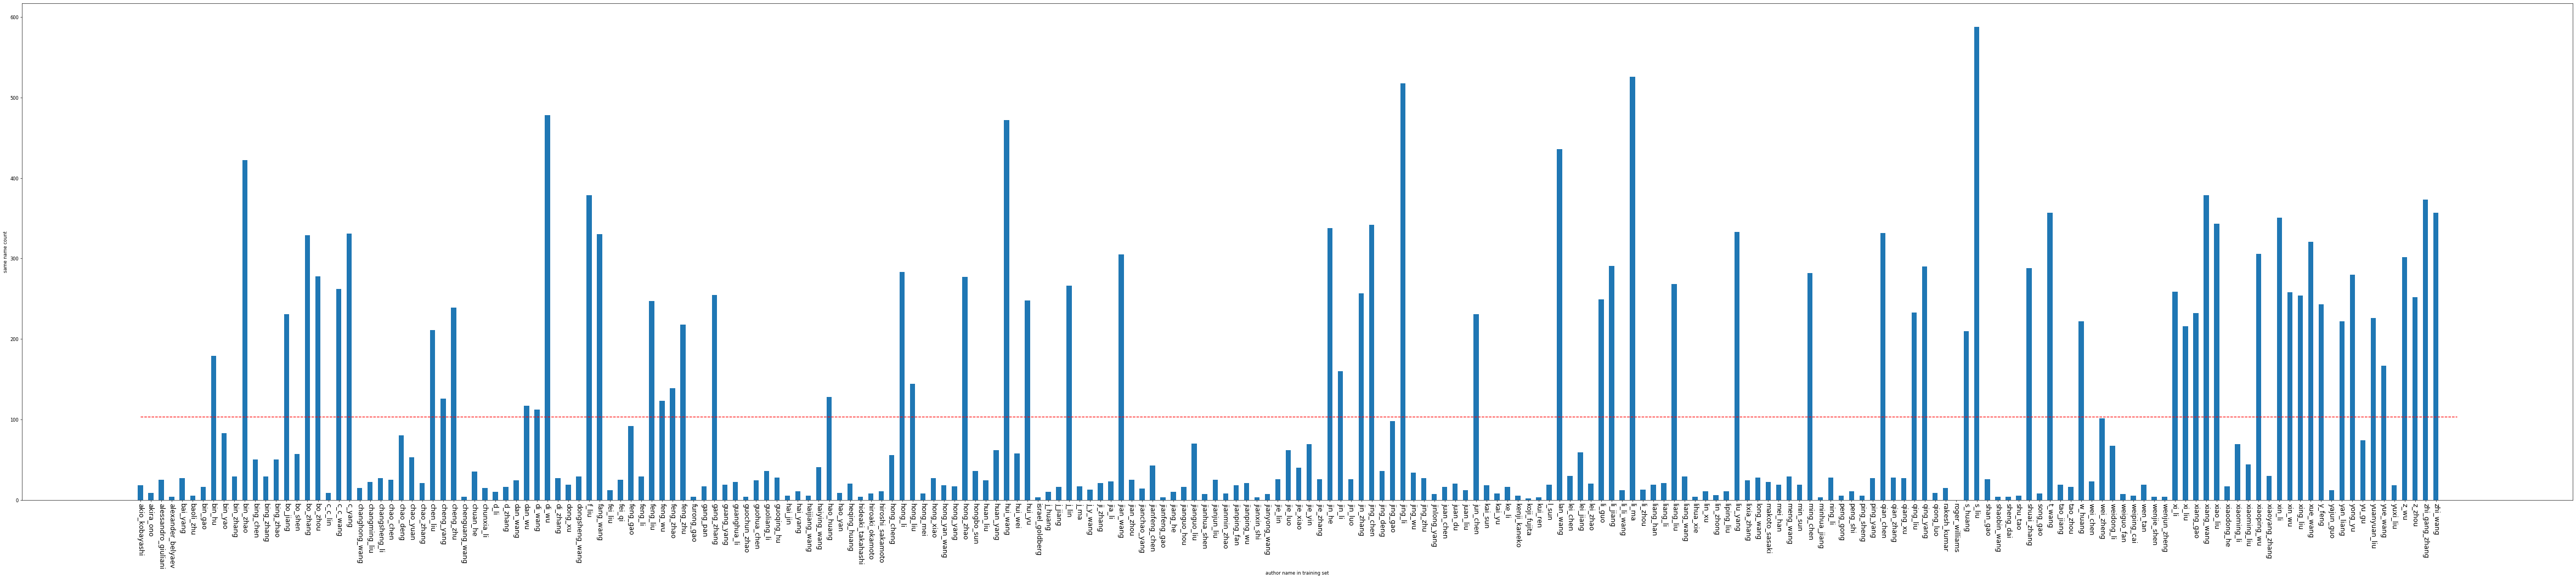

In [127]:
author_name_list = sorted([k for k in train_author_data.keys()])
author_same_name_count = dict((k, len(train_author_data[k].keys())) for k in train_author_data.keys())


author_count_before_disambiguation = len(author_name_list)
author_count_after_disambiguation = sum([author_same_name_count[k] for k in train_author_data])

print("author name count before disambiguation: ", author_count_before_disambiguation)
print("author name count after disambiguation:", author_count_after_disambiguation)

plt.figure(figsize=(100, 20), dpi=60)
x = range(len(author_name_list))

plt.bar(x, [author_same_name_count[k] for k in author_name_list], width=0.5)
plt.xticks(x, author_name_list)
plt.xticks(rotation=270) 
plt.xticks(fontsize = 15)
plt.xlabel("author name in training set")
plt.ylabel("same name count")

avg_count = np.mean([author_same_name_count[k] for k in author_name_list])
print(f"average count per author name  before disambiguation: {avg_count: .2f}")
plt.hlines(avg_count, 0, len(author_name_list) + 1, linestyles = "--", color = "red", label = f"average: {avg_count}")


total_paper_count = 0
for name in train_author_data.keys():
    for v in train_author_data[name].values():
        total_paper_count += len(v)

print(f"total paper count: {total_paper_count}")
print(f"average paper per author (before disambiguation): {total_paper_count/author_count_before_disambiguation :.0f}")
print(f"average paper per author (after disambiguation): {total_paper_count/author_count_after_disambiguation :.0f}")
        




### validation data

In [128]:
for author in test_author_data.keys():
    pass
    #print(author)
    
#test example
print("\n\n\ntest author data")
print(test_author_data["heng_li"])

print("\n\n\ntest pub data")
pprint(test_pub_data["zszavvJh"])

print("\n\nsubmisssion example:")
print(example_output["heng_li"])





test author data
['zszavvJh', 'a2Tl88Xu', 'X3Y0AYBw', '0kUbjIMW', '4bKZMNxE', 'vbQeLjWI', 'ZfSbG5ME', 'ierOTBz1', '6cXZA7zu', 'cXBXYa63', '141Kx9Ce', 'Gfl2GwXG', '98xkec8D', '2MIIwgBH', 'yVCAyLJo', 'NaPOuXXF', 'YoRqTILd', 'V8UOM2uU', 'wtiZkPVr', 'qggv8F0K', 'uDsLiLZd', 'FIVcmK6w', 'M2YJ0Dfa', 'QqQNHt3b', 'Cpi5vz3j', '7wJu2eAh', 'dUlZsS5z', 'cZnZW9uz', 'bxkStxS7', 'TH4B6A7Y', 'xn3xJkGU', 'xsbQHWyq', 'B5HNDTzE', 'MsT3Sml8', 'PO61SLCN', 'SCvnHfAx', 'pFmfB3Hm', 'qFyL0b7h', 'MdbnxBrH', 'WDe4ltiG', '4eHVOVB7', '8OiM0qmf', 'Q62Py6ew', 'Jmcve9yI', '475s6I47', 'OnwXGiRR', 'CUbTTLzf', '4DaB8tVN', 'oim5ZjhO', 'OyhZ1MiB', 'KZzOrPpy', 's0UYiQ6B', '0GzWz3O4', 'kWe0u2Ih', 'AyFd9xZZ', 'N7J7fEeF', 'C1WBo3Cs', 'Lg5JGKID', 'W6leQ8fX', 'qyh46ML8', 'ojqAGDyS', 'aA4FOt2Y', 'x3h6uA0c', 'tWxrqzEO', 'goiijZU0', 'wyionLg7', 'RQzk9gxv', 'spGZlbgg', 'X7DSjudv', 'JOAqAYeR', 'ynRw5omI', 'cQAaLgVP', '2J2G5bPa', '8X7NKYO8', 'eFRsCR81', 'KSWkp6m2', 'wme6V0aL', '5HLZuQ0p', 'dP2aIUjO', 'Vif917Gy', 'c8ngM97e', 'OFZvRr

In [130]:
valid_data = dict()
for author in test_author_data.keys():
    if "_" in author:
        print(author)
    
    valid_data[author] = [test_pub_data[paper_id] for paper_id in test_author_data[author]]
  


author_name_list = valid_data.keys()
papers_per_author = [len(valid_data[author]) for author in author_name_list]

print(f"valid author name count: {len(author_name_list)}")
print(f"average paper per author: {np.mean(papers_per_author): .2f}")
    
#examples
test_name = "shiyi_chen"
print(f"test name: {test_name}")
for v in valid_data[test_name]:
    print(f"\npaper id: {v['id']}")
    for n in v["authors"]:
          print(n["name"])
    

heng_li
fang_chen
lin_zhou
akio_yamamoto
y_luo
chun_li
shiyi_chen
zhigang_chen
chun_wang
j_yu
y_guo
g_li
jing_huang
atsushi_takeda
fei_gao
rajendra_prasad
qi_li
bin_ren
yong_cao
jing_zhou
hong_jiang
liang_zhou
ming_xu
jie_sun
hao_zhang
jue_wang
y_shi
jian_huang
ping_zhang
feng_zhou
dong_zhang
h_yu
jian_wu
li_huang
shiyong_liu
ke_xu
min_yang
lei_wu
jie_zhou
zhang_lei
h_y_wang
qing_li
d_wang
hongsheng_chen
kun_li
hong_guo
gang_chen
yuanyuan_zhang
lin_ma
yao_zhang
valid author name count: 50
average paper per author:  917.96
test name: shiyi_chen

paper id: lsXG1s34
Hua Yinghui
Chen Shiyi
Zhai Weitao
Chen Jiwu
Li Yunxia
Wu Wei

paper id: Me1wpE9Y
Shang Xiliang
Chen Shiyi
Ren Huimin
Li Yunxia
Huang He
Zhang Jian

paper id: XnaM91Hr
Li Hong
Chen Chen
Zhang Shurong
Jiang Jia
Tao Hongyue
Xu Jialing
Sun Jianguo
Zhong Wei
Chen Shiyi

paper id: jZ3FQhj7
Chen ShiYi
Chen YingChun
Xia ZhenHua
Qu Kun
Shi YiPeng
Xiao ZuoLi
Liu QiuHong
Cai QingDong
Liu Feng
Lee Cunbiao
Zhang RiKui
Cai JinSheng

paper 

LI Hong-yun
CHEN Shi-yi
CHEN Shi-qiu
LI Yun-xia
CHEN Ji-wu

paper id: 8BntQRJw
YANG Zhi-juan
XIAO Zheng-long
LI Chun-mei
JIA Wei
CHEN Shi-yi
LAI Song-jia

paper id: 8P8n5THP
GAO Kai
LI Yun-xia
CHEN Shi-yi

paper id: wSWupz6G
Shiyi Chen
Wenguo Xiang
Zhipeng Xue
Xiaoyan Sun

paper id: Fjsu5xxx
Cai Qing-Dong
Chen Shiyi

paper id: PCReCmkn
Zhang Ri-kui
Mao Feng
Wu Jie-Zhi
Chen Shi-Yi
Wu Yu-Lin
Liu Shu-Hong

paper id: M3tQT3UV
Xiong Xiangming
Tao Jianjun
Chen Shiyi
Brandt Luca

paper id: ZDXzsFbj
Hong Li.
Yang Wu
Yunsheng Ge
Jia Jiang
Kai Gao
Pengyun Zhang
Lingxiang Wu
Shiyi Chen

paper id: dDM39pbs
Sha Jiao
Li Hongyun
Chen Shiyi
Chen Jiwu
Li Yunxia
Hua Yinghui
Shen Weizhong

paper id: dBcdY68t
shiyi
chen
zhenhua
xia
jianchun
wang
yantao
yang

paper id: OtONqRls
Zhang Ming
Wang Kun
Chen Shiyi
Wang Jie
Lai Songjia

paper id: 8wjj8Ipx
Dai Peng
Chen Zheng
Chen Shiyi

paper id: Cpcuylaw
Fu Lu
Yang Zhi-Juan
Chen Shi-Yi
Wang Jie
Lai Song-Jia

paper id: XGtGTccw
Chen Henry
Li Hong-Yun
Zhang Jian
H

## data prepprocessing

In [131]:
def preprocess_name(name):   
    name = name.lower().replace(' ', '_')
    name = name.replace('.', '_')
    name = name.replace('-', '')
    name = re.sub(r"_{2,}", "_", name) 
    return name


def preproces_org(org):
    if org != "":
        org = org.replace('Sch.', 'School')
        org = org.replace('Dept.', 'Department')
        org = org.replace('Coll.', 'College')
        org = org.replace('Inst.', 'Institute')
        org = org.replace('Univ.', 'University')
        org = org.replace('Lab ', 'Laboratory ')
        org = org.replace('Lab.', 'Laboratory')
        org = org.replace('Natl.', 'National')
        org = org.replace('Comp.', 'Computer')
        org = org.replace('Sci.', 'Science')
        org = org.replace('Tech.', 'Technology')
        org = org.replace('Technol.', 'Technology')
        org = org.replace('Elec.', 'Electronic')
        org = org.replace('Engr.', 'Engineering')
        org = org.replace('Aca.', 'Academy')
        org = org.replace('Syst.', 'Systems')
        org = org.replace('Eng.', 'Engineering')
        org = org.replace('Res.', 'Research')
        org = org.replace('Appl.', 'Applied')
        org = org.replace('Chem.', 'Chemistry')
        org = org.replace('Prep.', 'Petrochemical')
        org = org.replace('Phys.', 'Physics')
        org = org.replace('Phys.', 'Physics')
        org = org.replace('Mech.', 'Mechanics')
        org = org.replace('Mat.', 'Material')
        org = org.replace('Cent.', 'Center')
        org = org.replace('Ctr.', 'Center')
        org = org.replace('Behav.', 'Behavior')
        org = org.replace('Atom.', 'Atomic')
        #org = org.split(';')[0]
        org = ' '.join(org.split(';'))
        org = org.lower()
    return org


def preprocess_venue(venue):
    if venus != "":
        pass

def remove_stopwords(content):
    use_stopwords = set(stopwords.words('english'))
    stemmer = WordNetLemmatizer()
    content = [stemmer.lemmatize(word) for word in content.split()
                   if word not in use_stopwords and len(word) > 1]
    return ' '.join(content)
        

    
#remove seprators by regular expression
def etl(content):
    content = re.sub("[\s+\.\!\/,;$%^*(+\"\')]+|[+——()?【】“”！，。？、~@#￥%……&*（）]+", " ", content)
    content = re.sub(r" {2,}", " ", content)
    return content

def get_org(co_authors, author_name):
    for au in co_authors:
        name = precessname(au['name'])
        name = name.split('_')
        if ('_'.join(name) == author_name or '_'.join(name[::-1]) == author_name) and 'org' in au:
            return au['org']
    return ''
    

## disambiguate 1: TF-IDF 

In [133]:
def disambiguate():
    result_dict = {}
    
    for author in test_author_data.keys():
        print(author)
        
        feature_string_list = []
        papers = test_author_data[author]
        if len(papers) == 0:
            result_dict[author] = []
            continue
        
        print("paper count: ", len(papers))
        paper_dict = {}
        for paper in papers:
           
            feature_list = []
            
            for k in test_pub_data[paper]["authors"]:
                if "name" in k:
                    feature_list.append(preprocess_name(k["name"]))
                
                if "org" in k:
                    feature_list.append(preproces_org(k["org"]))                    
            
                #if "abstract" in test_pub_data[paper]:
                #    feature_list.append(test_pub_data[paper]["abstract"].lower())
                
                #if "venue" in k:
                #    feature_list.append(k["venue"])
                    
            
            if "keywords" in test_pub_data[paper]:
                feature_list += test_pub_data[paper]["keywords"]
            
            
            feature_string = etl(" ".join(feature_list))
            #print(feature_string)
            feature_string = remove_stopwords(feature_string)
            #print(feature_string)
            feature_string_list.append(feature_string)
            #input()
        
        print("feature string list length:", len(feature_string_list))
        tfidf = TfidfVectorizer().fit_transform(feature_string_list)
        print(f"converted TF-IDF shape: {tfidf.shape}")
        
        clf = DBSCAN(metric="cosine", min_samples = 3)
        s = clf.fit_predict(tfidf)
        print("labels")
        #print(clf.labels_)
        
        for label, paper in zip(clf.labels_, papers):
            if str(label) not in paper_dict:
                paper_dict[str(label)] = [test_pub_data[paper]["id"]]
            else:
                paper_dict[str(label)].append(test_pub_data[paper]["id"])
            
        #pprint(paper_dict)
        result_dict[author] = list(paper_dict.values())
        json.dump(result_dict, open("./result/result_0221.json", "w", encoding='utf-8'), indent=4)
                
               
                    
                
        
        

disambiguate()

heng_li
paper count:  768
feature string list length: 768
converted TF-IDF shape: (768, 4286)
labels
fang_chen
paper count:  314
feature string list length: 314
converted TF-IDF shape: (314, 2250)
labels
lin_zhou
paper count:  980
feature string list length: 980
converted TF-IDF shape: (980, 5467)
labels
akio_yamamoto
paper count:  272
feature string list length: 272
converted TF-IDF shape: (272, 1135)
labels
y_luo
paper count:  162
feature string list length: 162
converted TF-IDF shape: (162, 1555)
labels
chun_li
paper count:  318
feature string list length: 318
converted TF-IDF shape: (318, 1880)
labels
shiyi_chen
paper count:  229
feature string list length: 229
converted TF-IDF shape: (229, 1249)
labels
zhigang_chen
paper count:  1356
feature string list length: 1356
converted TF-IDF shape: (1356, 5272)
labels
chun_wang
paper count:  221
feature string list length: 221
converted TF-IDF shape: (221, 1105)
labels
j_yu
y_guo
paper count:  708
feature string list length: 708
converted 

# disambiguate 2

In [59]:
print(test_pub_data["JIfXICrQ"]["venue"])

for paper in test_pub_data.values():
    print(paper["venue"])

China Brewing
China Brewing
Food and Fermentation Technology
Food and Fermentation Technology
Food and Fermentation Technology
China Brewing
Food and Fermentation Technology
Food and Fermentation Technology
Food and Fermentation Technology
Food and Fermentation Technology
Food and Fermentation Technology
Food and Fermentation Technology
China Brewing
Food and Fermentation Technology
Food and Fermentation Technology
Journal of Management in Engineering
Journal of Construction Engineering and Management-asce

Journal of Management in Engineering
Corporate Communications: An International Journal
IJSTM
Journal of Construction Engineering and Management-asce
Computer Applications in Engineering Education
Inf. Manag. Comput. Security
Journal of Construction Engineering and Management-asce
Journal of Construction Engineering and Management-asce
Journal of Construction Engineering and Management-asce
Environmental Management and Health
Measuring Business Excellence
The Tqm Magazine
Constructi

Nami Jishu yu Jingmi Gongcheng/Nanotechnology and Precision Engineering
Zidonghua Xuebao/Acta Automatica Sinica
International Journal of Aeroacoustics
Proceedings - International Conference on Natural Computation
Materials Letters
15th International Conference on Information Fusion, FUSION 2012
Wuli Xuebao/Acta Physica Sinica
International Journal for Numerical Methods in Fluids
Wuli Xuebao/Acta Physica Sinica
Wuli Xuebao/Acta Physica Sinica
Advanced Materials Research
Chinese Control Conference, CCC
Proceedings - 2012 9th International Conference on Fuzzy Systems and Knowledge Discovery, FSKD 2012
Lecture Notes in Electrical Engineering
World Automation Congress Proceedings
World Automation Congress Proceedings
2012 International Conference on Wireless Communications and Signal Processing, WCSP 2012
Shengxue Xuebao/Acta Acustica
Applied Mechanics and Materials
Applied Optics
Wuli Xuebao/Acta Physica Sinica
Lecture Notes in Computer Science (including subseries Lecture Notes in Artific

Pharmaceutical Research
Particle and Fibre Toxicology
Molecular Pharmaceutics
Proceedings of the IEEE
Journal of the American Chemical Society
Journal of Controlled Release
ACS Nano
ACS Macro Letters
Journal of Nuclear Medicine
Journal of Nuclear Medicine
Investigative Radiology
Carbohydrate Research
Biomacromolecules
Journal of Nuclear Medicine
Molecular Imaging and Biology
Oncology Reports
Phytotaxa
Phytotaxa
Phytotaxa
Scientia Horticulturae
Scientia Horticulturae
Materials Letters
Journal of Polymer Science, Part B: Polymer Physics
Journal of Polymer Engineering
Materials Chemistry and Physics
Polymer International
Journal of Applied Polymer Science
Dianli Zidonghua Shebei/Electric Power Automation Equipment
Dianli Zidonghua Shebei/Electric Power Automation Equipment
Dianli Zidonghua Shebei/Electric Power Automation Equipment
Dianli Xitong Baohu yu Kongzhi/Power System Protection and Control
Dianli Xitong Baohu yu Kongzhi/Power System Protection and Control
Dianli Xitong Baohu yu Ko

NCTCS
NCTCS
Sensors (Basel, Switzerland)
Symmetry
IEEE Access
Wireless Networks
IEEE Access

Security and Communication Networks
Chinese Journal of Computers
Journal of Software
Future Internet

WASA
Wireless Networks
Journal of Software



Clinical Orthopaedics and Related Research
IEEE Trans. Mob. Comput.
Computers & Electrical Engineering
IJAHUC
IEEE Journal on Selected Areas in Communications
GLOBECOM
Resource Management for Energy and Spectrum Harvesting Sensor Networks
IEEE Transactions on Vehicular Technology
Neurocomputing
NCTCS
NCTCS
INFOCOM Workshops
Information
IIKI
IJAACS
Chemistry of Materials
Chinese Journal of Chemistry
Journal of The American Chemical Society
Chemphyschem : a European journal of chemical physics and physical chemistry
Chemistry-a European Journal
Chemistry (Weinheim an der Bergstrasse, Germany)
Current Organic Chemistry
Biomaterials
Nanotechnology
Chinese Journal of Chemistry
Nanotechnology
Journal of Materials Chemistry
Journal of the American Chemical

Physical Review Letters
Physical Review Letters
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physical Review Letters
Physical Review D - Particles, Fields, Gravitation and Cosmology
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physical Review Letters
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physical Review Letters
Physical Review D - Particles, Fields, Gravitation and Cosmology
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physical Review Letters
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physical Review D - Particles, Fields, Gravitation and Cosmology
European Physical Journal C
Physical Review D - Particles, Fields, Gravitation and Cosmology
P

Chinese Journal of Pharmacology and Toxicology
Proceedings of the National Academy of Sciences of the United States of America
Marine Biotechnology
Yadian Yu Shengguang/Piezoelectrics and Acoustooptics
Wuhan Ligong Daxue Xuebao (Jiaotong Kexue Yu Gongcheng Ban)/Journal of Wuhan University of Technology (Transportation Science and Engineering)
Zhongguo Zhongyao Zazhi
Cellular and Molecular Life Sciences
Journal of Clinical Rehabilitative Tissue Engineering Research
CrystEngComm
Canadian Journal of Microbiology
Diangong Jishu Xuebao/Transactions of China Electrotechnical Society
Wuji Cailiao Xuebao/Journal of Inorganic Materials
Biomaterials
Fungal Biology
Chinese Optics Letters
Tien Tzu Hsueh Pao/Acta Electronica Sinica
Tumor Biology
Tien Tzu Hsueh Pao/Acta Electronica Sinica
Zhongguo Zhongyao Zazhi
Cancer Science
Plant Cell
Journal of Chemical Physics
Biochemical and Biophysical Research Communications
Proceedings of the ASME International Design Engineering Technical Conferences and C

Physical Review B - Condensed Matter and Materials Physics
Computational Materials Science
Journal of Applied Physics
Journal of Physics D: Applied Physics
Journal of Materials Science: Materials in Electronics
Journal of Applied Physics
Journal of Applied Physics
Journal of Physics Condensed Matter
Journal of Materials Research
Journal of Alloys and Compounds
Journal of Physics Condensed Matter
Journal of Applied Physics
Physical Review Letters
Journal of Physical Chemistry C
Journal of Applied Physics
Journal of Alloys and Compounds
Applied Physics Letters
Computational Materials Science
Journal of Applied Physics
Journal of Applied Physics
Chinese Physics B
Physica B: Condensed Matter
Chinese Physics B
ChemPhysChem
International Journal of Materials Research
Computational Materials Science
Chinese Physics Letters
Nanotechnology
Journal of Materials Research
Science China: Physics, Mechanics and Astronomy
Journal of Applied Physics
Journal of Nanoparticle Research
Materials Science F

Fudan University Journal of Medical Sciences
Ferroelectrics
Acta Polymerica Sinica
Acta Physico - Chimica Sinica
Inorganic Chemistry Communications
Acta Chimica Sinica
Zeitschrift fur Anorganische und Allgemeine Chemie
Qinghua Daxue Xuebao/Journal of Tsinghua University
Chinese Journal of Microbiology and Immunology
Chinese Journal of Microbiology and Immunology
Kao Teng Hsueh Hsiao Hua Heush Hsueh Pao/ Chemical Journal of Chinese Universities
Journal of Cancer Epidemiology and Prevention
Jiegou Huaxue
Chinese Journal of Microbiology and Immunology
Polyhedron
Hybridoma and Hybridomics
World Chinese Journal of Digestology
Journal of Medical Virology
Journal of Supramolecular Chemistry
Journal of Nutrition
Biochemical and Biophysical Research Communications
Journal of Chemical Crystallography
CrystEngComm
CrystEngComm
European Journal of Inorganic Chemistry
Contraception
Chinese Journal of Microbiology and Immunology
Journal of the Chinese Society of Corrosion and Protection
Journal of I

Science China: Physics, Mechanics and Astronomy
Chemical Communications
Clinical and Experimental Nephrology
Computer Networks
Carbon
Shengxue Xuebao/Acta Acustica
Soil Biology and Biochemistry
Journal Wuhan University of Technology, Materials Science Edition
Dianli Xitong Baohu yu Kongzhi/Power System Protection and Control
Optik
Journal of Infrared, Millimeter, and Terahertz Waves
Journal of Superconductivity and Novel Magnetism
Atherosclerosis
Optics Communications
Bioresource Technology
BioResources
Xiandai Huagong/Modern Chemical Industry
China Communications
Journal of Proteome Research
Proceedings - 2012 International Conference on Computer Distributed Control and Intelligent Environmental Monitoring, CDCIEM 2012
Proceedings - 2012 International Conference on Computer Distributed Control and Intelligent Environmental Monitoring, CDCIEM 2012
Proceedings - 2012 International Conference on Intelligent Systems Design and Engineering Applications, ISDEA 2012
Journal of Semiconductors

ACS applied materials & interfaces
Polymer Bulletin
ACS applied materials & interfaces
Chinese Journal of Liquid Crystals and Displays
Macromolecular rapid communications
Scientia Sinica(Chimica)
Acta Physica Sinica
Scientia Sinica(Chimica)
Journal of the American Chemical Society
Chemical Society reviews
Scientia Sinica(Chimica)
Scientia Sinica(Chimica)
ACS applied materials & interfaces
Chemical Society reviews
ACS applied materials &amp;amp; interfaces
ChemSusChem
Advanced materials (Deerfield Beach, Fla.)
Scientia Sinica(Chimica)
Chemical communications (Cambridge, England)
ACS applied materials & interfaces
Gaodeng Xuexiao Huaxue Xuebao/Chemical Journal of Chinese Universities
Science China-chemistry
Science China-chemistry
Applied Physics Letters






Advanced Functional Materials
Solar Energy Materials and Solar Cells
Israel Journal of Chemistry
New Journal of Chemistry
Advanced Materials
Advanced Materials
Chemical communications (Cambridge, England)
Advanced materials (Deerfi

Journal of Chemical & Engineering Data
The Journal of Chemical Thermodynamics
Journal of Chemical & Engineering Data
Chemical Engineering Journal
Adsorption

Physical review letters


Physical Review B
Journal of hazardous materials
Combustion Science and Technology
International Journal of Hydrogen Energy
International Journal of Hydrogen Energy
Energy
Cell discovery
Cell discovery
Science advances
Journal of molecular biology
Nature
Yuanzineng Kexue Jishu/Atomic Energy Science and Technology
Chinese Physics Letters
Chinese Physics Letters
Chinese Physics Letters
Kao Neng Wu Li Yu Ho Wu Li/High Energy Physics and Nuclear Physics
Yuanzineng Kexue Jishu/Atomic Energy Science and Technology
Chinese Physics Letters
Physical Review C - Nuclear Physics
Yuanzineng Kexue Jishu/Atomic Energy Science and Technology
Chinese Physics C
Chinese Physics Letters
Chinese Physics C
Key Engineering Materials
Jianzhu Jiegou Xuebao/Journal of Building Structures
China Ocean Engineering
Optical Engineering

DATE

MASCOTS
high performance computing
symposium on computer architecture and high performance computing
Journal of Computer Science and Technology
ICPP
Cluster-based storage systems with high scalability
CCGrid
IEEE Trans. Parallel Distrib. Syst.
CCGrid
IEEE Trans. Computers
ICDCS
CLUSTER

IEEE Trans. Parallel Distrib. Syst.

Cluster Computing and the Grid
ICC
Mass Storage Systems and Technologies
Future Generation Comp. Syst.
IEEE Trans. Cloud Computing
Guang pu xue yu guang pu fen xi = Guang pu
Acta Ecologica Sinica
China Environmental Science
Journal of Zhejiang Forestry College
Journal of Plant Ecology
Environmental Pollution & Control
Huan jing ke xue= Huanjing kexue / [bian ji, Zhongguo ke xue yuan huan jing ke xue wei yuan hui "Huan jing ke xue" bian ji wei yuan hui.]
Remote Sensing Information
Remote Sensing Information
Acta Scientiae Circumstantiae
Scientia Geographica Sinica
Environmental Science & Technology
Acta Ecologica Sinica
Acta Ecologica Sinica
Remote Sensing Infor

Current eye research
American journal of ophthalmology
Eye and vision (London, England)
Investigative Ophthalmology & Visual Science
Investigative Ophthalmology & Visual Science
Microvascular Research
Investigative Ophthalmology & Visual Science
Investigative Ophthalmology & Visual Science
Investigative Ophthalmology & Visual Science
Investigative Ophthalmology & Visual Science
Investigative Ophthalmology & Visual Science
Investigative Ophthalmology & Visual Science
Investigative Ophthalmology & Visual Science
Investigative Ophthalmology & Visual Science
Microvascular Research
Investigative Ophthalmology & Visual Science

Investigative Ophthalmology & Visual Science
Investigative ophthalmology & visual science
Neurology
Investigative Ophthalmology & Visual Science
PloS one
Journal of Alzheimer's disease : JAD
Eye and vision (London, England)
Investigative Ophthalmology & Visual Science
Investigative Ophthalmology & Visual Science
Investigative Ophthalmology & Visual Science
Investigati

China Communications
Dianzi Keji Daxue Xuebao/Journal of the University of Electronic Science and Technology of China
IET Communications
IEEE Transactions on Vehicular Technology
Dianzi Yu Xinxi Xuebao/Journal of Electronics and Information Technology
International Journal of Distributed Sensor Networks
Xi Tong Gong Cheng Yu Dian Zi Ji Shu/Systems Engineering and Electronics
Xi Tong Gong Cheng Yu Dian Zi Ji Shu/Systems Engineering and Electronics
Xitong Fangzhen Xuebao / Journal of System Simulation
Gongneng Cailiao/Journal of Functional Materials
Journal of Alloys and Compounds
Materials Science and Engineering B: Solid-State Materials for Advanced Technology
Applied Surface Science
Ceramics International
Wuji Cailiao Xuebao/Journal of Inorganic Materials
Journal of Alloys and Compounds
European Microwave Week 2013, EuMW 2013 - Conference Proceedings; EuMC 2013: 43rd European Microwave Conference
European Microwave Week 2013, EuMW 2013 - Conference Proceedings; EuMIC 2013: 8th Europea

Beijing Hangkong Hangtian Daxue Xuebao/Journal of Beijing University of Aeronautics and Astronautics
Organometallics
Journal of Agricultural and Food Chemistry
Journal of Fuel Chemistry and Technology
Journal of Chemical Research
Journal of Chemical Research
Proceedings of 2004 International Conference on Machine Learning and Cybernetics
Chemistry - A European Journal
Chinese Journal of Catalysis
Guocheng Gongcheng Xuebao/The Chinese Journal of Process Engineering
Nanotechnology
Journal of Coordination Chemistry
Applied Organometallic Chemistry
Organometallics
Pan Tao Ti Hsueh Pao/Chinese Journal of Semiconductors
World Journal of Gastroenterology
International Journal of Hydrogen Energy
Gongneng Cailiao/Journal of Functional Materials
Vacuum
Thin Solid Films
Polyhedron
Materials Science Forum
Advanced Synthesis and Catalysis
Journal of Jilin University Medicine Edition
Molecular Genetics and Genomics
Jinshu Xuebao/Acta Metallurgica Sinica
Gaofenzi Cailiao Kexue Yu Gongcheng/Polymeric 

Journal of Applied Physics
Chemistry - A European Journal
Nanoscale
Journal of Materials Science
Applied Physics A: Materials Science and Processing
Journal of Alloys and Compounds
Journal of Alloys and Compounds
Journal of Applied Physics
Applied Microbiology and Biotechnology
Journal of Shanghai Jiaotong University (Medical Science)
PLoS ONE
Molecular Cancer
Microbial Cell Factories
Scientific Reports
IEICE Electronics Express
Journal of Information Hiding and Multimedia Signal Processing
Journal of Information Hiding and Multimedia Signal Processing
Journal of Information Hiding and Multimedia Signal Processing
Journal of Information Hiding and Multimedia Signal Processing
IEICE Transactions on Information and Systems
ICIC Express Letters, Part B: Applications
Catalysis Communications
Dyes and Pigments
Cellulose
Chemical Engineering Journal
Journal of Molecular Catalysis A: Chemical
Journal of Iron and Steel Research International
Journal of Central South University
Revista Tecnica 





Journal of Functional Foods
Journal of Functional Foods
Journal of Functional Foods
International Journal of Food Science and Technology
International Journal of Food Science and Technology
Food Control
Food Control
Food Control
Food Control
Food Control
Food Control
RSC Advances
RSC Advances
Journal of Functional Foods
Journal of Agricultural and Food Chemistry
Journal of bioscience and bioengineering
Biological trace element research
Nutrients
Antonie van Leeuwenhoek
PloS one
Microbiological research
Ecotoxicology and environmental safety
Applied and Environmental Microbiology
RSC Advances
Biochemical Engineering Journal
RSC Advances
International Journal of Dairy Technology
Chinese Science Bulletin
RSC Advances
RSC Advances
Aquaculture Research
RSC Advances
International Dairy Journal
Frontiers in Microbiology
Food Research International
Frontiers in Genetics
Journal of Functional Foods
Journal of dairy science
RSC Advances
Journal of Functional Foods
Environmental Science and T

Tumor Biology
Medical science monitor : international medical journal of experimental and clinical research
Cancer management and research
Clinical Endocrinology
Endocrine
Gene
International journal of surgery (London, England)
Tumor Biology
Tumor Biology
Tissue & cell
Medical oncology (Northwood, London, England)
European Journal of Endocrinology
Cell death & disease
Advanced materials (Deerfield Beach, Fla.)
Materials Today
Organic Electronics
Dyes and Pigments
Chemistry of Materials
Advanced materials (Deerfield Beach, Fla.)
Advanced materials (Deerfield Beach, Fla.)
Advanced materials (Deerfield Beach, Fla.)
Angewandte Chemie (International ed. in English)
Macromolecules
ACS Applied Materials & Interfaces
Chemical Reviews
Macromolecules
Chemistry of Materials
Journal of Materials Chemistry
Chemistry-an Asian Journal
Chinese Journal of Chemistry
Journal of Materials Chemistry
Advanced Energy Materials





Polymer International
Polymer International

Chemical reviews
Nature Communic

BMC cancer
Medicine
Tumour biology : the journal of the International Society for Oncodevelopmental Biology and Medicine
Medicine
Bioresources
Bioresources
Bioresources
Chinese Journal of Polymer Science

Advanced Materials Research
Journal of Intelligent and Fuzzy Systems
international symposium on educational technology
Multimedia Tools Appl.
MONET
MONET


Physical Review B
Physical Review B
Physical Review B
Blood
The FASEB Journal
PLOS ONE
Nature
Blood
Cell
Physiologia plantarum
Plant science : an international journal of experimental plant biology
Environmental Science & Technology
Plant and Soil
Plant and Soil
Soil Biology & Biochemistry
Plant and Soil
Rhizosphere
Plant and Soil
Environmental science & technology
Geoderma
International journal of biological macromolecules
BioMed research international
Journal of cellular biochemistry
Molecular medicine reports
International journal of biological macromolecules
Journal of Cellular Biochemistry
Gene therapy
Journal of Biomedical Re

Materials Research Society Symposium - Proceedings
Materials Research Society Symposium - Proceedings
Materials Research Society Symposium - Proceedings
Applied Physics A: Materials Science and Processing
Semiconductor Science and Technology
Tien Tzu Hsueh Pao/Acta Electronica Sinica
Guti Dianzixue Yanjiu Yu Jinzhan/Research & Progress of Solid State Electronics
Solid-State Electronics
Guti Dianzixue Yanjiu Yu Jinzhan/Research & Progress of Solid State Electronics
Applied Physics Letters
Journal of Physics D: Applied Physics
Proceedings of SPIE - The International Society for Optical Engineering
Acta Metallurgica Sinica (English Letters)
Materials Research Society Symposium - Proceedings
Materials Research Society Symposium - Proceedings
Materials Research Society Symposium - Proceedings
Materials Research Society Symposium - Proceedings
Materials Research Society Symposium - Proceedings
Materials Research Society Symposium - Proceedings
Applied Physics A: Materials Science and Process

ICASSP, IEEE International Conference on Acoustics, Speech and Signal Processing - Proceedings
Journal of Networks
Advanced Materials Research
Advanced Materials Research
Proceedings - 2013 IEEE International Congress on Big Data, BigData 2013
Advanced Materials Research
Shenzhen Daxue Xuebao (Ligong Ban)/Journal of Shenzhen University Science and Engineering
China Communications
IEICE Transactions on Communications
IEEE International Conference on Communications
IEEE International Conference on Communications
Journal of China Universities of Posts and Telecommunications
2013 8th International ICST Conference on Communications and Networking in China, CHINACOM 2013 - Proceedings
IEEE International Symposium on Personal, Indoor and Mobile Radio Communications, PIMRC
IEEE Vehicular Technology Conference
IEEE Vehicular Technology Conference
IEEE Vehicular Technology Conference
2013 8th International ICST Conference on Communications and Networking in China, CHINACOM 2013 - Proceedings
Yin

Science in China, Series B: Chemistry
Xitong Fangzhen Xuebao / Journal of System Simulation
Chinese Journal of Chemical Engineering
Journal of Computational Information Systems
Blood Purification
Chuan Bo Li Xue/Journal of Ship Mechanics
Shanghai Jiaotong Daxue Xuebao/Journal of Shanghai Jiaotong University
Toxicon
International Journal of Theoretical Physics
Molecular Immunology
Journal of Oral Pathology and Medicine
International Journal of Modern Physics B
International Journal of Refrigeration
Hepatobiliary and Pancreatic Diseases International
Wuli Xuebao/Acta Physica Sinica
Beijing Hangkong Hangtian Daxue Xuebao/Journal of Beijing University of Aeronautics and Astronautics
NeuroReport
Taiyangneng Xuebao/Acta Energiae Solaris Sinica
Molecular and Cellular Neuroscience
Wuhan Ligong Daxue Xuebao/Journal of Wuhan University of Technology
Materials Transactions
Microsystem Technologies
Molecular Cell
Molecular Cell
Chinese Annals of Mathematics. Series B
Cancer Letters
Reproductive Bi

Applied Surface Science
Macromolecules
Chemistry of Materials
Advanced materials (Deerfield Beach, Fla.)
Chemistry Letters
Nano-Structures and Nano-Objects
Faraday discussions
Chemistry (Weinheim an der Bergstrasse, Germany)
Lubrication Engineering
Advanced Functional Materials
Superlattices and Microstructures
Journal of agricultural and food chemistry

Angewandte Chemie (International ed. in English)
RSC Advances
RSC Advances
Applied Physics Letters
Journal of colloid and interface science
Macromolecular rapid communications
Thin Solid Films
Tribology International
Electrochemistry Communications
Journal of Applied Polymer Science
Journal of Applied Polymer Science
Small (Weinheim an der Bergstrasse, Germany)
Journal of Materials Chemistry
Materials Letters
Helvetica Chimica Acta
ACS applied materials & interfaces
Tribology Letters
ACS applied materials & interfaces
Angewandte Chemie (International ed. in English)
Journal of the American Chemical Society
ACS Macro Letters

Applied Ph

Proceedings of SPIE - The International Society for Optical Engineering
Proceedings of SPIE - The International Society for Optical Engineering
ICINA 2010 - 2010 International Conference on Information, Networking and Automation, Proceedings
Guangxue Xuebao/Acta Optica Sinica
Applied Mechanics and Materials
Advanced Materials Research
Advanced Materials Research
Advanced Materials Research
Applied Mechanics and Materials
Environmental Science and Technology
Applied Mechanics and Materials
Advanced Materials Research
Vacuum
5th International Conference on Bioinformatics and Biomedical Engineering, iCBBE 2011
Yuanzineng Kexue Jishu/Atomic Energy Science and Technology
Advanced Materials Research
Chinese Physics Letters
Chinese Physics B
Applied Mechanics and Materials
Yaoxue Xuebao
He-Huaxue yu Fangshe Huaxue/Journal of Nuclear and Radiochemistry
Physica B: Condensed Matter
Journal of Applied Polymer Science
Journal of Hazardous Materials
Chinese Journal of Medical Imaging Technology
Jou

2010 9th International Symposium on Antennas Propagation and EM Theory, ISAPE 2010
Journal of Geophysical Research: Space Physics
Science China Earth Sciences
Journal of Geophysical Research: Space Physics
IEEE Transactions on Plasma Science
Qiangjiguang Yu Lizishu/High Power Laser and Particle Beams
Wuli Xuebao/Acta Physica Sinica
Chinese Physics B
Physics of Plasmas
Physics of Plasmas
Wuli Xuebao/Acta Physica Sinica
Qiangjiguang Yu Lizishu/High Power Laser and Particle Beams
Qiangjiguang Yu Lizishu/High Power Laser and Particle Beams
Plasma Science and Technology
Qiangjiguang Yu Lizishu/High Power Laser and Particle Beams
Chinese Physics B
Physics of Plasmas
Proceedings of SPIE - The International Society for Optical Engineering
International Conference on Communication Technology Proceedings, ICCT
Proceedings of SPIE - The International Society for Optical Engineering
Proceedings of SPIE - The International Society for Optical Engineering
Optical Engineering
Optical Engineering
Proc

applied physics letters
journal of nanjing university of posts and telecommunications(natural science)
display technology, journal of
proceedings of spie - the international society for optical engineering
guangzi xuebao/acta photonica sinica
journal of optoelectronics.laser
conference proceedings - lasers and electro-optics society annual meeting-leos
guangdianzi jiguang/journal of optoelectronics laser
acta photonica sinica
pan tao ti hsueh pao/chinese journal of semiconductors
zhongguo jiguang/chinese journal of lasers
pan tao ti hsueh pao/chinese journal of semiconductors
ieee journal of quantum electronics
chinese physics letters
光电子快报(英文版)
optik (jena)
acta photonica sinica
journal of jilin university(engineering and technology edition)
acta photonica sinica
pan tao ti hsueh pao/chinese journal of semiconductors
ieee journal of quantum electronics
ieee journal of quantum electronics
chinese journal of lasers b (english edition)
journal of neuropathology and experimental neurology

Kao Neng Wu Li Yu Ho Wu Li/High Energy Physics and Nuclear Physics
Kao Neng Wu Li Yu Ho Wu Li/High Energy Physics and Nuclear Physics
Chinese Physics C
Physical Review D - Particles, Fields, Gravitation and Cosmology
Chinese Physics Letters
Journal of Physics G: Nuclear and Particle Physics
Nuclear Physics B
Chinese Physics C
Chinese Physics C
Chinese Journal of Clinical Rehabilitation
Chinese Journal of Clinical Rehabilitation
Chinese Journal of Gastroenterology
World Journal of Gastroenterology
Chinese Journal of Digestive Diseases
Chinese Journal of Gastroenterology
Chinese Journal of Gastroenterology
Journal of Clinical Rehabilitative Tissue Engineering Research
National Medical Journal of China
Biochemical and Biophysical Research Communications
Oncology Reports
Clinical Journal of Pain
Brain Research
Cancer Science
European Journal of Pharmacology
Chinese Journal of Gastroenterology
Archives of Orthopaedic and Trauma Surgery
BMC Cancer
Chinese Journal of Inorganic Chemistry
Exper

Industrial and Engineering Chemistry Research
Journal of Nanoscience and Nanotechnology
International Journal of Food Science and Technology
Suxing Gongcheng Xuebao/Journal of Plasticity Engineering
Chinese Journal of Mechanical Engineering (English Edition)
Journal of Combinatorial Chemistry
IEEE Transactions on Knowledge and Data Engineering
Monatshefte fur Mathematik
Yi Qi Yi Biao Xue Bao/Chinese Journal of Scientific Instrument
Journal of Southeast University (English Edition)
Quaternary Geochronology
Insurance: Mathematics and Economics
He Jishu/Nuclear Techniques
Xi'an Jianzhu Keji Daxue Xuebao/Journal of Xi'an University of Architecture and Technology
Xi'an Jianzhu Keji Daxue Xuebao/Journal of Xi'an University of Architecture and Technology
Advanced Materials Research
Advanced Materials Research
Advanced Materials Research
Jixie Gongcheng Xuebao/Journal of Mechanical Engineering
Optics Letters
Journal of Colloid and Interface Science
Chinese Optics Letters
Xitong Fangzhen Xuebao

Proceedings of the World Congress on Intelligent Control and Automation (WCICA)
PESC Record - IEEE Annual Power Electronics Specialists Conference
ICSICT-2006: 2006 8th International Conference on Solid-State and Integrated Circuit Technology, Proceedings
ICSICT-2006: 2006 8th International Conference on Solid-State and Integrated Circuit Technology, Proceedings
Proceedings - International Conference on Information Technology: New Generations, ITNG 2008
Chinese Control and Decision Conference, 2008, CCDC 2008
Proceedings - ISECS International Colloquium on Computing, Communication, Control, and Management, CCCM 2008
Proceedings - ISECS International Colloquium on Computing, Communication, Control, and Management, CCCM 2008
2008 3rd International Conference on Pervasive Computing and Applications, ICPCA08
Proceedings - 2008 2nd International Symposium on Intelligent Information Technology Application, IITA 2008
15th World Congress on Intelligent Transport Systems and ITS America Annual 

European Physical Journal C
Physical Review Letters
European Physical Journal C
Physical Review Letters
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physical Review Letters
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physical Review D - Particles, Fields, Gravitation and Cosmology
Journal of High Energy Physics
Journal of High Energy Physics
Journal of High Energy Physics
Physical Review D - Particles, Fields, Gravitation and Cosmology
Physical Review D - Particles, Fields, Gravitation and Cosmology
Journal of High Energy Physics
European Physical Journal C
European Physical Journal C
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics
Physical Review D - Particles, Fields, Gravitation and Cosmology
Physical Review Letters
Physical Review Letters
Physical Review D - Particles, Fields, Gravitation and Cosmo

Physical Review B - Condensed Matter and Materials Physics
physical review b
physical review b - condensed matter and materials physics
physical review b
physical review b
physical review b
proceedings of the national academy of sciences of the united states of america
physical review letters
j. comput. physics
physical review b
physical review b
journal of computational physics
applied physics letters


europhysics letters (epl)

physical review b
physical review b
physical review b
physical review b
physical review b
physical review b
physical review b

physical review b
proceedings of the ieee

physical review b
physical review b

physical review b
journal of physics: condensed matter
physical review b
physica a: statistical mechanics and its applications
physical review letters
physical review letters
physical review b
journal of physics. condensed matter : an institute of physics journal
european physical journal b
physical review b
propellants explosives pyrotechnics
physical rev

Bulletin of the American Physical Society
Applied Physics Letters
Energy and Environmental Science
Bulletin of the American Physical Society
Bulletin of the American Physical Society
Proceedings of the National Academy of Sciences of the United States of America
Materials Today Physics
Bulletin of the American Physical Society
Bulletin of the American Physical Society
Applied Physics Letters
Bulletin of the American Physical Society
Bulletin of the American Physical Society
Bulletin of the American Physical Society
Mrs Bulletin
Nature communications
Bulletin of the American Physical Society
Optics Communications
Applied Physics Letters
Scientific reports









Nano Energy


Materials Today
Solar Energy







Physical Review Materials
arXiv: Mesoscale and Nanoscale Physics
arXiv: Mesoscale and Nanoscale Physics
Physical review applied
Proceedings of the National Academy of Sciences of the United States of America
Science advances
Nanoscale
Materials Today Physics
arXiv: Materials Sc

Journal of Functional Foods
Journal of Asian Natural Products Research
Journal of Asian Natural Products Research
Journal of Asian Natural Products Research
Journal of Asian Natural Products Research
Journal of Asian Natural Products Research
Journal of Asian Natural Products Research
Journal of Asian Natural Products Research
Natural Product Research
Tetrahedron Letters
Journal of Asian Natural Products Research
Journal of pharmaceutical and biomedical analysis
Phytochemistry
Journal of natural medicines
Planta medica
Phytochemistry
Scientific reports
Current Pharmacology Reports
Molecules
Phytomedicine : international journal of phytotherapy and phytopharmacology
Molecules
Alcoholism-clinical and Experimental Research
ICM '11 Proceedings of the 2011 International Conference of Information Technology, Computer Engineering and Management Sciences - Volume 01
PloS one
Neurotoxicity research
FASEB journal : official publication of the Federation of American Societies for Experimental Bio

IEEE Access
International Symposium on Industrial Embedded Systems
International Conference on Embedded Software
ACM Trans. Embedded Comput. Syst.
DATE
ACM Trans. Embedded Comput. Syst.
Journal of Circuits, Systems, and Computers
DATE
TrustCom/BigDataSE/ICESS
TrustCom/BigDataSE/ICESS
field programmable custom computing machines
workshop on embedded and cyber physical systems education
Sustainable Computing: Informatics and Systems
DATE
Journal of Investigative Dermatology
Journal of experimental & clinical cancer research : CR
International journal of oncology
The journal of histochemistry and cytochemistry : official journal of the Histochemistry Society
European journal of pharmaceutical sciences : official journal of the European Federation for Pharmaceutical Sciences
Journal of Cardiovascular Pharmacology
ACS Nano
Advanced Functional Materials
Advanced Functional Materials
International Journal of Cancer
GECCO (Companion)
CEC
CEC
ICONIP
IEEE Trans. Evolutionary Computation
ACALCI
A

Rengong Jingti Xuebao/Journal of Synthetic Crystals
AIAA/IEEE Digital Avionics Systems Conference - Proceedings
AIAA/IEEE Digital Avionics Systems Conference - Proceedings
61st International Astronautical Congress 2010, IAC 2010
Yuhang Xuebao/Journal of Astronautics
62nd International Astronautical Congress 2011, IAC 2011
Beijing Hangkong Hangtian Daxue Xuebao/Journal of Beijing University of Aeronautics and Astronautics
Zhongguo Kongjian Kexue Jishu/Chinese Space Science and Technology
Hangkong Xuebao/Acta Aeronautica et Astronautica Sinica
Acta Mechanica Sinica/Lixue Xuebao
AIAA Guidance, Navigation, and Control Conference 2012
Journal of Aerospace Engineering
Proceedings of the International Astronautical Congress, IAC
AIAA/AAS Astrodynamics Specialist Conference 2012
Beijing Hangkong Hangtian Daxue Xuebao/Journal of Beijing University of Aeronautics and Astronautics
Jiqiren/Robot
Yuhang Xuebao/Journal of Astronautics
Mathematical Problems in Engineering
Chinese Pharmacological Bull

## Affinity Propagation

In [65]:
from sklearn.cluster import AffinityPropagation

def disambiguate():
    result_dict = {}
    for author in test_author_data.keys():
        print(author)
        
        feature_string_list = []
        papers = test_author_data[author]
        if len(papers) == 0:
            result_dict[author] = []
            continue
        
        print("paper count: ", len(papers))
        paper_dict = {}
        for paper in papers:
           
            feature_list = []
            
            for k in test_pub_data[paper]["authors"]:
                if "name" in k:
                    #name_list.append(preprocessname(k["name"]))
                    feature_list.append(preprocess_name(k["name"]))
                if "org" in k:
                    #org_list.append(preprocessorg(k["org"]))
                    feature_list.append(preproces_org(k["org"]))                    
            
            #if "abstract" in test_pub_data[paper]:
            #    feature_list.append(test_pub_data[paper]["abstract"])
                if "venue" in k:
                    feature_list.append(k["venue"])
                    
            
            if "keywords" in test_pub_data[paper]:
                feature_list += test_pub_data[paper]["keywords"]
            
            
            feature_string = etl(" ".join(feature_list))
            feature_string_list.append(feature_string)
        
        print("feature string list length:", len(feature_string_list))
        tfidf = TfidfVectorizer().fit_transform(feature_string_list)
        
        #clf = DBSCAN(metric="cosine")
        #s = clf.fit_predict(tfidf)
        s = AffinityPropagation().fit_predict(tfidf)
        print("labels")
        #print(clf.labels_)
        
        for label, paper in zip(s, papers):
            if str(label) not in paper_dict:
                paper_dict[str(label)] = [test_pub_data[paper]["id"]]
            else:
                paper_dict[str(label)].append(test_pub_data[paper]["id"])
            
        #pprint(paper_dict)
        result_dict[author] = list(paper_dict.values())
        json.dump(result_dict, open("./result_0220_2.json", "w", encoding='utf-8'), indent=4)
                
               
                    
                
        
        

disambiguate()

heng_li
paper count:  768
feature string list length: 768
labels
fang_chen
paper count:  314
feature string list length: 314
labels
lin_zhou
paper count:  980
feature string list length: 980
labels
akio_yamamoto
paper count:  272
feature string list length: 272
labels
y_luo
paper count:  162
feature string list length: 162
labels
chun_li
paper count:  318
feature string list length: 318
labels
shiyi_chen
paper count:  229
feature string list length: 229
labels
zhigang_chen
paper count:  1356
feature string list length: 1356
labels
chun_wang
paper count:  221
feature string list length: 221
labels
j_yu
y_guo
paper count:  708
feature string list length: 708
labels
g_li
paper count:  362
feature string list length: 362
labels
jing_huang
paper count:  1121
feature string list length: 1121
labels
atsushi_takeda
paper count:  78
feature string list length: 78
labels
fei_gao
paper count:  1346
feature string list length: 1346
labels
rajendra_prasad
paper count:  165
feature string list lengt

## disambiguate 3, word2vec

In [110]:
def convert_text_to_vector():
    feature_string_list = []
    
    for author in test_author_data.keys():
        print("test author: ", author)
        
        papers = test_author_data[author]
        print("paper count: ", len(papers))
        
        paper_dict = {}
        for paper in papers:
           
            feature_list = []
            
            for k in test_pub_data[paper]["authors"]:
                if "name" in k:
                    feature_list.append(preprocess_name(k["name"]))
                if "org" in k:
                    feature_list.append(preproces_org(k["org"]))                    
            
                if "abstract" in test_pub_data[paper]:
                    feature_list.append(test_pub_data[paper]["abstract"].lower())
                
                if "venue" in k:
                    feature_list.append(k["venue"])
                    
            
            if "keywords" in test_pub_data[paper]:
                feature_list += test_pub_data[paper]["keywords"]
            
            
            feature_string = etl(" ".join(feature_list))
            feature_string = remove_stopwords(feature_string)
            feature_string_list.append(feature_string)
    
    print("feature string list count: ", len(feature_string_list))
           
        
    for author in train_author_data.keys():
        print("train author: ", author)
        
        author_id_list = list(train_author_data[author].keys())
        papers = []
        
        for author_id in author_id_list:
            papers += train_author_data[author][author_id]

        
        print("paper count: ", len(papers))
        
        for paper in papers:
           
            feature_list = []
            if paper not in train_pub_data.keys():
                print("paper not in train pub_data: ", paper)
                continue
            for k in train_pub_data[paper]["authors"]:
                if "name" in k:
                    feature_list.append(preprocess_name(k["name"]))
                if "org" in k:
                    feature_list.append(preproces_org(k["org"]))                    
            
                if "abstract" in train_pub_data[paper]:
                    if train_pub_data[paper]["abstract"] is not None:
                        feature_list.append(train_pub_data[paper]["abstract"].lower())
                
                if "venue" in k:
                    feature_list.append(k["venue"])
                    
            
            if "keywords" in train_pub_data[paper]:
                feature_list += train_pub_data[paper]["keywords"]
            
            
            feature_string = etl(" ".join(feature_list))
            feature_string = remove_stopwords(feature_string)
            feature_string_list.append(feature_string)
           
               
    print("feature string list count: ", len(feature_string_list))
    
    with open ('./temp/text.txt', 'w', encoding = 'utf-8') as f:
        for line in feature_string_list:
            f.write("%s\n" % line)
                          
                    
                
convert_text_to_vector()        
        



test author:  heng_li
paper count:  768
test author:  fang_chen
paper count:  314
test author:  lin_zhou
paper count:  980
test author:  akio_yamamoto
paper count:  272
test author:  y_luo
paper count:  162
test author:  chun_li
paper count:  318
test author:  shiyi_chen
paper count:  229
test author:  zhigang_chen
paper count:  1356
test author:  chun_wang
paper count:  221
test author:  j_yu
paper count:  0
test author:  y_guo
paper count:  708
test author:  g_li
paper count:  362
test author:  jing_huang
paper count:  1121
test author:  atsushi_takeda
paper count:  78
test author:  fei_gao
paper count:  1346
test author:  rajendra_prasad
paper count:  165
test author:  qi_li
paper count:  2686
test author:  bin_ren
paper count:  371
test author:  yong_cao
paper count:  1340
test author:  jing_zhou
paper count:  304
test author:  hong_jiang
paper count:  2699
test author:  liang_zhou
paper count:  213
test author:  ming_xu
paper count:  1222
test author:  jie_sun
paper count:  1407
t

train author:  j_jiang
paper count:  100
train author:  liang_liu
paper count:  1413
train author:  hong_liu
paper count:  3987
train author:  kui_ren
paper count:  154
train author:  jing_wu
paper count:  244
train author:  dong_xu
paper count:  681
train author:  huan_yang
paper count:  845
train author:  lihua_xie
paper count:  55
train author:  guochun_zhao
paper count:  415
train author:  li_zhou
paper count:  212
train author:  jie_lin
paper count:  338
train author:  guanghua_li
paper count:  577
train author:  feng_liu
paper count:  3302
train author:  hong_mei
paper count:  473
train author:  xiaodong_he
paper count:  895
train author:  hong_cheng
paper count:  834
train author:  zhi_gang_zhang
paper count:  483
train author:  c_c_wang
paper count:  839
train author:  lei_jiang
paper count:  1705
train author:  shan_gao
paper count:  1431
train author:  chenguang_wang
paper count:  137
train author:  jie_xiao
paper count:  606
train author:  li_li_wang
paper count:  77
train a

In [111]:
sentences = word2vec.Text8Corpus(r'temp/text.txt')
model = word2vec.Word2Vec(sentences, size=100,negative =5, min_count=2, window=5)
model.save('temp/word2vec_model')

In [116]:
model_path = 'temp/word2vec_model'
model = word2vec.Word2Vec.load(model_path)

[ 0.01121789  0.01452911 -0.08549873  0.03921758  0.01133747  0.01106659
  0.01793061 -0.06143381  0.12575814 -0.04326283 -0.0314155  -0.00295977
 -0.00337917 -0.01413526 -0.01308597 -0.10127193  0.01684002 -0.08577825
 -0.0846269   0.02718247 -0.01123084  0.03469848 -0.0555955   0.06083957
 -0.03535707  0.04517886  0.01092988  0.02877892  0.01749124  0.03698353
 -0.13380218  0.03032981 -0.00208404 -0.07106189  0.05063913  0.00107872
 -0.03749713 -0.01644969  0.02872405 -0.07267735  0.02716483  0.01095433
  0.01415004 -0.02018105  0.03752245 -0.05895727  0.01621534 -0.05679896
 -0.03432598  0.03847165  0.06362819  0.0251556  -0.02146601  0.05810481
 -0.0628477   0.05527538  0.07903835 -0.01025607  0.04420865  0.08027883
 -0.06745474  0.00091351 -0.13504913 -0.0182238   0.06422703 -0.01288288
  0.06200259 -0.04220204  0.01820172 -0.02915937  0.10852545 -0.09013914
  0.06229319 -0.01607496 -0.03025551  0.00821023  0.10543268 -0.11713268
  0.00541019 -0.06926485 -0.00974411  0.01348132 -0

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
